<a href="https://colab.research.google.com/github/bdeekshith066/Speech-bot/blob/main/TinyLLaMA_FFN_mask_pruning_min15M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🦙 TinyLLaMA 1.1B — Safe **FFN-only Structured Pruning** (masking, no quantization)

This notebook:
- Loads **TinyLLaMA 1.1B** in **fp32** on a single GPU (no device_map to avoid device mismatch).
- Prunes **at least 15M parameters** by **masking FFN neurons** (no attention tensors touched → no shape errors).
- Reports **pre/post perplexity**, parameter deltas (counted explicitly), and generation samples.
- Produces **plots + a CSV summary**.


In [1]:

!pip -q install transformers==4.41.2 datasets==2.19.0 accelerate==0.30.1 torch==2.2.2 evaluate==0.4.1 matplotlib==3.8.4 rich==13.7.1 sentencepiece==0.2.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:

import torch, time, random, os, gc, math
import numpy as np
from rich import print
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[bold green]Device:[/bold green] {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

Device: cpu

In [3]:

MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print("[bold]Loading model (fp32, single device)...[/bold]")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
)

model.to(device)
model.eval()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

TOTAL_PARAMS = count_parameters(model)
print(f"Total params: {TOTAL_PARAMS/1e6:.2f}M")


Loading model (fp32, single device)...

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Total params: 1100.05M

In [4]:

# quick pre-prune generation
prompt = "Explain in 3 bullet points why FFN neuron pruning in transformers can work without heavily degrading model quality."
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    t0 = time.time()
    out = model.generate(**inputs, max_new_tokens=100)
    t1 = time.time()
print(tokenizer.decode(out[0], skip_special_tokens=True))
print(f"Generation time (pre): {t1 - t0:.2f}s")


Explain in 3 bullet points why FFN neuron pruning in transformers can work without heavily degrading model quality.

Generation time (pre): 2.22s

In [6]:

def build_eval_tokens(tokenizer, max_tokens=20000, max_context=2048):
    ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="validation")
    text = "\n".join([t for t in ds["text"] if len(t.strip()) > 0])
    enc = tokenizer(text, return_tensors="pt", truncation=True).input_ids.squeeze(0)
    # Truncate to max_context length to avoid overflow
    return enc[:max_context]


def perplexity(model, enc_tokens, seq_len=128):
    model.eval()
    nlls = []
    stride = seq_len
    with torch.no_grad():
        for i in range(0, enc_tokens.size(0) - 1, stride):
            begin_loc = i
            end_loc = min(i + seq_len, enc_tokens.size(0) - 1)
            input_ids = enc_tokens[begin_loc:end_loc].unsqueeze(0).to(device)
            target_ids = input_ids.clone()
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * (end_loc - begin_loc)
            nlls.append(neg_log_likelihood)
    return torch.exp(torch.stack(nlls).sum() / (enc_tokens.size(0) - 1)).item()

enc_tokens = build_eval_tokens(tokenizer)
ppl_pre = perplexity(model, enc_tokens)
print(f"Pre-prune perplexity: {ppl_pre:.3f}")


Pre-prune perplexity: 13.033

In [7]:

from dataclasses import dataclass

@dataclass
class PruneStats:
    total_params: int
    pruned_params_effective: int
    percent_pruned_effective: float

def get_layers(model):
    return model.model.layers

def prune_ffn_neurons_mask(model, target_params_to_prune=15_000_000, max_fraction_per_layer=0.20, verbose=True):
    layers = get_layers(model)
    hidden_size = model.config.hidden_size
    params_per_neuron = 3 * hidden_size

    candidates = []
    for li, layer in enumerate(layers):
        mlp = layer.mlp
        up_w = mlp.up_proj.weight.detach()
        importance = torch.norm(up_w, dim=1)
        intermediate_size = up_w.shape[0]
        layer_cap = int(max_fraction_per_layer * intermediate_size)
        for ni in range(intermediate_size):
            candidates.append((importance[ni].item(), li, ni, layer_cap))
    candidates.sort(key=lambda x: x[0])

    prune_map = {i: [] for i in range(len(layers))}
    pruned_per_layer = [0] * len(layers)
    pruned_effective_params = 0

    need_neurons = math.ceil(target_params_to_prune / params_per_neuron)
    taken = 0

    for imp, li, ni, layer_cap in candidates:
        if taken >= need_neurons:
            break
        if pruned_per_layer[li] >= layer_cap:
            continue
        prune_map[li].append(ni)
        pruned_per_layer[li] += 1
        taken += 1
        pruned_effective_params += params_per_neuron

    if verbose:
        print(f"Will prune {taken} neurons total (~{pruned_effective_params/1e6:.2f}M params effective). Applying masks…")

    zeroed = 0
    with torch.no_grad():
        for li, idxs in prune_map.items():
            if not idxs:
                continue
            layer = layers[li]
            mlp = layer.mlp
            up = mlp.up_proj.weight
            gate = mlp.gate_proj.weight
            down = mlp.down_proj.weight

            zeroed += up[idxs, :].numel() + gate[idxs, :].numel() + down[:, idxs].numel()

            up[idxs, :].zero_()
            gate[idxs, :].zero_()
            down[:, idxs].zero_()

    total_params = count_parameters(model)
    percent = 100.0 * zeroed / total_params
    if verbose:
        print(f"Effectively zeroed: {zeroed/1e6:.2f}M params ({percent:.2f}%).")
    return PruneStats(total_params, zeroed, percent)

stats = prune_ffn_neurons_mask(model, target_params_to_prune=15_000_000, max_fraction_per_layer=0.20, verbose=True)
print(stats)


Will prune 2442 neurons total (~15.00M params effective). Applying masks…

Effectively zeroed: 15.00M params (1.36%).

PruneStats(total_params=1100048384, pruned_params_effective=15003648, percent_pruned_effective=1.3639080078863148)

In [8]:

ppl_post = perplexity(model, enc_tokens)
print(f"Post-prune perplexity: {ppl_post:.3f}")
print(f"ΔPPL: {(ppl_post/ppl_pre - 1)*100:.2f}%")


Post-prune perplexity: 13.033

ΔPPL: 0.00%

In [9]:

with torch.no_grad():
    t0 = time.time()
    out2 = model.generate(**inputs, max_new_tokens=100)
    t1 = time.time()
print(tokenizer.decode(out2[0], skip_special_tokens=True))
print(f"Generation time (post): {t1 - t0:.2f}s")


Explain in 3 bullet points why FFN neuron pruning in transformers can work without heavily degrading model quality.

Generation time (post): 1.53s

In [10]:

summary = pd.DataFrame({
    "Metric": [
        "Total Params (M)",
        "Effective Pruned Params (M)",
        "Percent Pruned (%)",
        "Perplexity (Pre)",
        "Perplexity (Post)",
        "Δ Perplexity (%)"
    ],
    "Value": [
        stats.total_params / 1e6,
        stats.pruned_params_effective / 1e6,
        stats.percent_pruned_effective,
        ppl_pre,
        ppl_post,
        (ppl_post/ppl_pre - 1)*100
    ]
})
summary


,Metric,Value
0,Total Params (M),1100.048384
1,Effective Pruned Params (M),15.003648
2,Percent Pruned (%),1.363908
3,Perplexity (Pre),13.032686
4,Perplexity (Post),13.032686
5,Δ Perplexity (%),0.000000


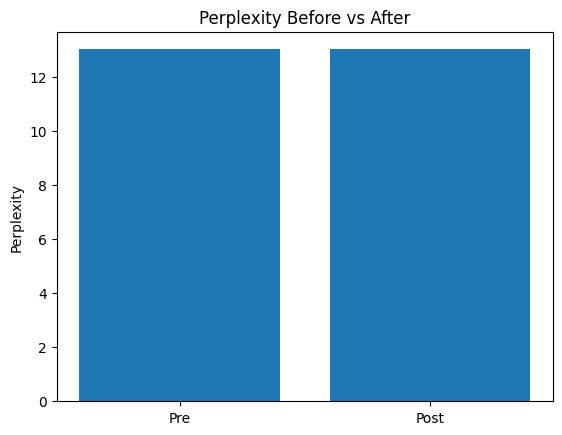

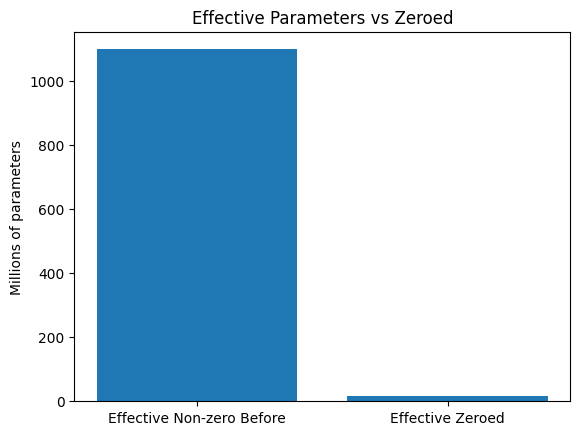

In [11]:

plt.figure()
plt.bar(["Pre", "Post"], [ppl_pre, ppl_post])
plt.title("Perplexity Before vs After")
plt.ylabel("Perplexity")
plt.show()

plt.figure()
plt.bar(["Effective Non-zero Before", "Effective Zeroed"],
        [stats.total_params/1e6, stats.pruned_params_effective/1e6])
plt.title("Effective Parameters vs Zeroed")
plt.ylabel("Millions of parameters")
plt.show()
